In [20]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seawater as sw
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features
import uuid
from scipy import interpolate
from glob import glob

rootdir='/home/agostino/saildrones_drive'

#create xarray dataset with saildrone filenames
#data directory for saildrone data
data_dir = rootdir+'/ATOMIC/saildrone_usv_data/'
saildrone_filenames = [x for x in glob(data_dir+'saildrone*.nc')]
print(saildrone_filenames)

#data directory for temperature logger .csv files
data_dir = rootdir+'/ATOMIC/temp_log_proc/'
#adir_sbe='F:/data/cruise_data/saildrone/2020_atomic/temp_log_proc/'

#get list of all filenames in directory
logger_filenames = [x for x in glob(data_dir+'*1_min*.nc')]
#print('number of file:',len(files))
#print(files)
print(logger_filenames)

['/home/agostino/saildrones_drive/ATOMIC/temp_log_proc/temperature_loggers-atomic_eurec4a_2020-sd1060-20200117T000000-20200302T235959-1_minute-v1.nc', '/home/agostino/saildrones_drive/ATOMIC/temp_log_proc/temperature_loggers-atomic_eurec4a_2020-sd1026-20200117T000000-20200302T235959-1_minute-v1.nc', '/home/agostino/saildrones_drive/ATOMIC/temp_log_proc/temperature_loggers-atomic_eurec4a_2020-sd1061-20200117T000000-20200302T235959-1_minute-v1.nc']


In [36]:
iusv=1 # Here select the saildrone
#open both files
fname=saildrone_filenames[iusv]
ds_usv=xr.open_dataset(fname)
ds_usv.close()
print(fname)
fname=logger_filenames[iusv]
print(fname)
ds_logger=xr.open_dataset(fname)
ds_logger.close()

#swap dims to time since obs makes no sense
ds_usv = ds_usv.isel(trajectory=0).swap_dims({'obs':'time'})
ds_logger = ds_logger.isel(trajectory=0).swap_dims({'obs':'time'})
ds_usv['wspd']=np.sqrt(ds_usv.UWND_MEAN**2+ds_usv.VWND_MEAN**2)

#calculate local time
xlon=ds_usv.longitude
time_offset_to_lmt=(xlon.data/360.)*24.*60
ds_usv['tlmt'] = ds_usv.time.data+time_offset_to_lmt*np.timedelta64(1,'m')# dt.timedelta(seconds=1)

/home/agostino/saildrones_drive/ATOMIC/saildrone_usv_data/saildrone-gen_5-atomic_eurec4a_2020-sd1061-20200117T000000-20200302T235959-1_minutes-v1.1589307121602.nc
/home/agostino/saildrones_drive/ATOMIC/temp_log_proc/temperature_loggers-atomic_eurec4a_2020-sd1026-20200117T000000-20200302T235959-1_minute-v1.nc


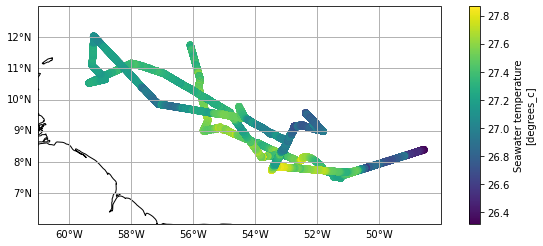

In [56]:
# Plot a map with the temperature from TEMP_SBE37_MEAN
fig = plt.figure(figsize=(10,4))
ax = plt.axes(projection=ccrs.PlateCarree())
xr.plot.scatter(ds_usv,x='longitude',y='latitude',hue='TEMP_SBE37_MEAN')
ax.coastlines()
ax.gridlines()
#ax.set_global()
ax.set_extent([-61,-48,6,13], ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False

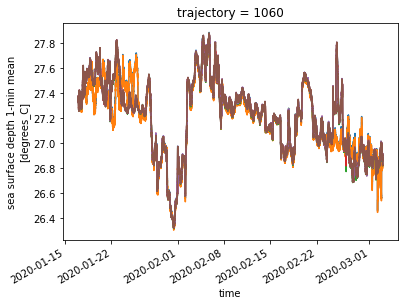

In [15]:
ds_usv.TEMP_SBE37_MEAN.plot()
ds_usv.TEMP_CTD_RBR_MEAN.plot()
ds_logger.sea_water_temperature_00_mean.plot()
ds_logger.sea_water_temperature_01_mean.plot()
ds_logger.sea_water_temperature_02_mean.plot()
ds_logger.sea_water_temperature_03_mean.plot()

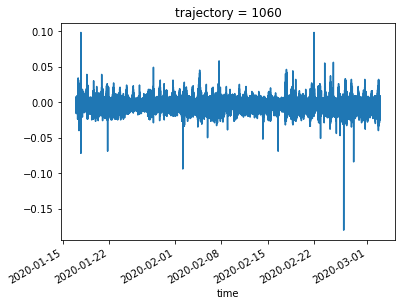

In [16]:
dif = ds_logger.sea_water_temperature_00_mean-ds_logger.sea_water_temperature_03_mean
#dif = ds_usv.TEMP_SBE37_MEAN-ds_usv.TEMP_CTD_RBR_MEAN
dif.plot()

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 6.000e+00,
        2.000e+00, 1.000e+00, 4.000e+00, 6.000e+00, 1.200e+01, 1.100e+01,
        1.900e+01, 1.600e+01, 2.500e+01, 3.200e+01, 2.500e+01, 2.700e+01,
        4.100e+01, 3.700e+01, 3.000e+01, 3.600e+01, 5.300e+01, 4.900e+01,
        6.900e+01, 6.400e+01, 7.200e+01, 9.300e+01, 9.800e+01, 1.330e+02,
        1.310e+02, 1.430e+02, 1.630e+02, 1.330e+02, 1.490e+02, 1.730e+02,
        1.870e+02, 1.870e+02, 2.220e+02, 2.470e+02, 2.530e+02, 3.080e+02,
        3.200e+02, 3.680e+02, 4.120e+02, 4.260e+02, 4.760e+02, 5.380e+02,
        5.570e+02, 6.150e+02, 6.360e+02, 6.520e+02, 8.010e+02, 8.230e+02,
        9.130e+02, 9.510e+02, 1.038e+03, 1.128e+03, 1.249e+03, 1.296e+03,
        1.375e+03, 1.507e+03, 1.624e+03, 1.778e+03, 1.774e+03, 1.874e+03,
        1.976e+03, 1.954e+03, 2.108e+0

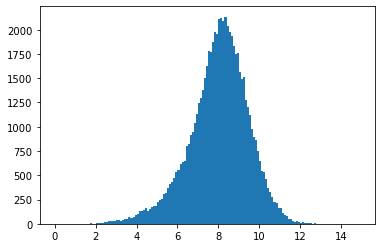

In [17]:
plt.hist(ds_usv.wspd,bins=np.arange(0,15,.1))

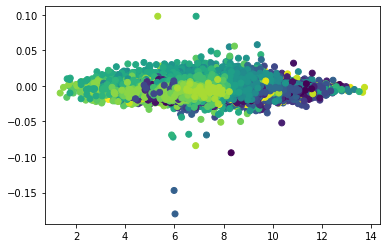

In [18]:
plt.scatter(ds_usv.wspd,dif,c=ds_usv.tlmt.dt.hour)